In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [3]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

1.15.0


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [4]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true

back = 0.1 #fraction of a background process that we would like to subtract

In [5]:
N = 10**5
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
background_param = (0, 1.2)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G))
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background])
theta0_G_withback = np.concatenate([theta0_G,-np.ones(int(N*back))*dummyval])

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N)
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) 
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval

theta_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background])
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones(int(N*back))*dummyval])

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

/Users/bpnachman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


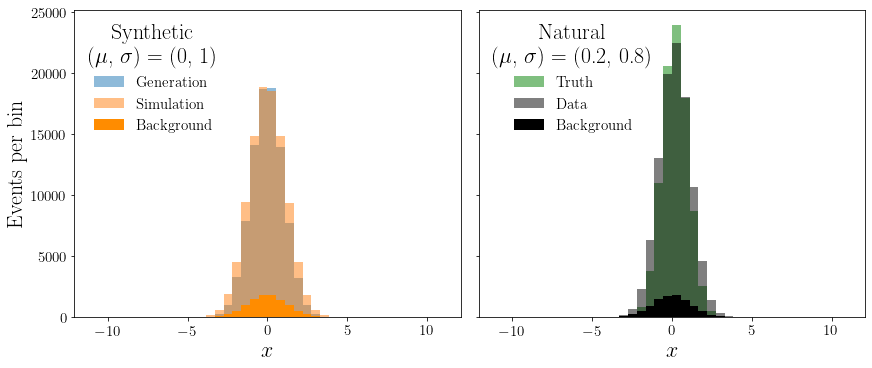

In [6]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback[theta0_S_withback!=dummyval], bins=bins, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback[theta0_G_withback==-dummyval], bins=bins, color="darkorange", label='Background')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_G_withback==-dummyval], bins=bins, label='Background',color="black")
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [7]:
iterations = 4

In [8]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((theta0_G, theta0_G))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))

In [10]:
#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.

    
x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=200,
          batch_size=10000,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 157446 samples, validate on 52482 samples
Epoch 1/200
157446/157446 [==============================] - 1s 9us/step - loss: 0.6264 - accuracy: 0.4787 - val_loss: 0.6254 - val_accuracy: 0.4759
Epoch 2/200
157446/157446 [==============================] - 0s 2us/step - loss: 0.6259 - accuracy: 0.4763 - val_loss: 0.6252 - val_accuracy: 0.4759
Epoch 3/200
157446/157446 [==============================] - 0s 2us/step - loss: 0.6259 - accuracy: 0.4763 - val_loss: 0.6252 - val_accuracy: 0.4759
Epoch 4/200
157446/157446 [==============================] - 0s 2us/step - loss: 0.6259 - accuracy: 0.4763 - val_loss: 0.6252 - val_accuracy: 0.4759
Epoch 5/200
157446/157446 [==============================] - 0s 2us/step - loss: 0.6258 - accuracy: 0.4763 - val_loss: 0.6252 - val_accuracy: 0.4759
Epoch 6/200
157446/157446 [==============================] - 0s 2us/step - loss: 0.6258 - accuracy: 0.4763 - 

In [11]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])

/Users/bpnachman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


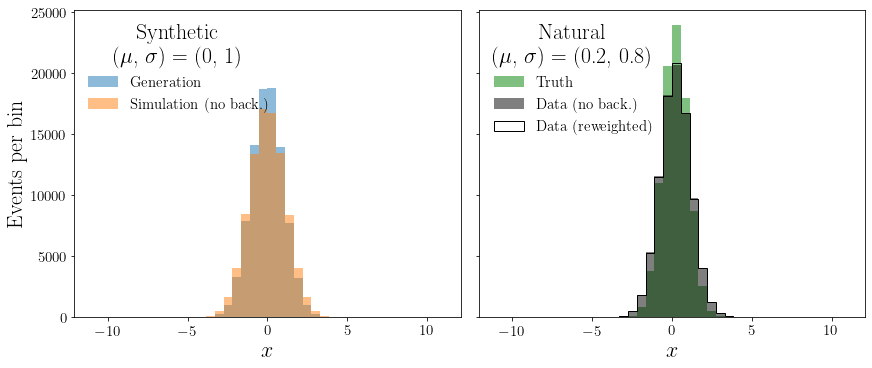

In [12]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

In [13]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [14]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))))

In [15]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, w_data))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    
    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_G[theta0_S!=dummyval],theta0_G[theta0_S!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S!=dummyval])),np.zeros(len(theta0_G[theta0_S!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S!=dummyval],np.ones(len(theta0_G[theta0_S!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_G[theta0_S==dummyval])
    weights_pull[theta0_S==dummyval] = average_vals
    ###
    
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=2000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Train on 142448 samples, validate on 47502 samples
Epoch 1/200
142448/142448 [==============================] - 1s 7us/step - loss: 0.6507 - accuracy: 0.5233 - val_loss: 0.6480 - val_accuracy: 0.5480
Epoch 2/200
142448/142448 [==============================] - 0s 2us/step - loss: 0.6477 - accuracy: 0.5503 - val_loss: 0.6464 - val_accuracy: 0.5557
Epoch 3/200
142448/142448 [==============================] - 0s 2us/step - loss: 0.6467 - accuracy: 0.5562 - val_loss: 0.6460 - val_accuracy: 0.5593
Epoch 4/200
142448/142448 [==============================] - 0s 2us/step - loss: 0.6465 - accuracy: 0.5562 - val_loss: 0.6459 - val_accuracy: 0.5572
Epoch 5/200
142448/142448 [==============================] - 0s 2us/step - loss: 0.6464 - accuracy: 0.5554 - val_loss: 0.6457 - val_accuracy: 0.5569
Epoch 6/200
142448/142448 [==============================] - 0s 2us/step - loss: 0.6463 - accuracy: 0.5550 - val_loss: 0.6457 - val_accuracy: 0.5556
Epoch 7/200
142448/142448 [=====

134979/134979 [==============================] - 0s 2us/step - loss: 0.6859 - accuracy: 0.5007 - val_loss: 0.6860 - val_accuracy: 0.5005
Epoch 8/200
134979/134979 [==============================] - 0s 2us/step - loss: 0.6856 - accuracy: 0.5002 - val_loss: 0.6858 - val_accuracy: 0.4997
Epoch 9/200
134979/134979 [==============================] - 0s 2us/step - loss: 0.6854 - accuracy: 0.4993 - val_loss: 0.6856 - val_accuracy: 0.4995
Epoch 10/200
134979/134979 [==============================] - 0s 2us/step - loss: 0.6852 - accuracy: 0.4999 - val_loss: 0.6854 - val_accuracy: 0.4993
Epoch 11/200
134979/134979 [==============================] - 0s 2us/step - loss: 0.6851 - accuracy: 0.5002 - val_loss: 0.6854 - val_accuracy: 0.4993
Epoch 12/200
134979/134979 [==============================] - 0s 2us/step - loss: 0.6850 - accuracy: 0.5007 - val_loss: 0.6854 - val_accuracy: 0.4993
Epoch 13/200
134979/134979 [==============================] - 0s 2us/step - loss: 0.6849 - accuracy: 0.5007 - val_l

Epoch 5/200
142493/142493 [==============================] - 0s 2us/step - loss: 0.6525 - accuracy: 0.5547 - val_loss: 0.6525 - val_accuracy: 0.5529
Epoch 6/200
142493/142493 [==============================] - 0s 2us/step - loss: 0.6525 - accuracy: 0.5557 - val_loss: 0.6525 - val_accuracy: 0.5519
Epoch 7/200
142493/142493 [==============================] - 0s 2us/step - loss: 0.6525 - accuracy: 0.5546 - val_loss: 0.6525 - val_accuracy: 0.5518
Epoch 8/200
142493/142493 [==============================] - 0s 2us/step - loss: 0.6525 - accuracy: 0.5543 - val_loss: 0.6525 - val_accuracy: 0.5526
Epoch 9/200
142493/142493 [==============================] - 0s 2us/step - loss: 0.6525 - accuracy: 0.5529 - val_loss: 0.6525 - val_accuracy: 0.5541
Epoch 10/200
142493/142493 [==============================] - 0s 2us/step - loss: 0.6525 - accuracy: 0.5553 - val_loss: 0.6525 - val_accuracy: 0.5522
Epoch 11/200
142493/142493 [==============================] - 0s 2us/step - loss: 0.6525 - accuracy: 0.55

Epoch 7/200
142472/142472 [==============================] - 0s 2us/step - loss: 0.6516 - accuracy: 0.5519 - val_loss: 0.6523 - val_accuracy: 0.5498
Epoch 8/200
142472/142472 [==============================] - 0s 2us/step - loss: 0.6516 - accuracy: 0.5483 - val_loss: 0.6523 - val_accuracy: 0.5472
Epoch 9/200
142472/142472 [==============================] - 0s 2us/step - loss: 0.6516 - accuracy: 0.5489 - val_loss: 0.6523 - val_accuracy: 0.5486
Epoch 10/200
142472/142472 [==============================] - 0s 2us/step - loss: 0.6516 - accuracy: 0.5540 - val_loss: 0.6523 - val_accuracy: 0.5534
Epoch 11/200
142472/142472 [==============================] - 0s 2us/step - loss: 0.6516 - accuracy: 0.5523 - val_loss: 0.6523 - val_accuracy: 0.5481
Epoch 12/200
142472/142472 [==============================] - 0s 2us/step - loss: 0.6516 - accuracy: 0.5510 - val_loss: 0.6524 - val_accuracy: 0.5499
Epoch 13/200
142472/142472 [==============================] - 0s 2us/step - loss: 0.6516 - accuracy: 0.

Epoch 6/200
142473/142473 [==============================] - 0s 2us/step - loss: 0.6552 - accuracy: 0.5387 - val_loss: 0.6549 - val_accuracy: 0.5413
Epoch 7/200
142473/142473 [==============================] - 0s 2us/step - loss: 0.6552 - accuracy: 0.5410 - val_loss: 0.6549 - val_accuracy: 0.5430
Epoch 8/200
142473/142473 [==============================] - 0s 2us/step - loss: 0.6552 - accuracy: 0.5414 - val_loss: 0.6549 - val_accuracy: 0.5397
Epoch 9/200
142473/142473 [==============================] - 0s 2us/step - loss: 0.6552 - accuracy: 0.5385 - val_loss: 0.6549 - val_accuracy: 0.5432
Epoch 10/200
142473/142473 [==============================] - 0s 2us/step - loss: 0.6552 - accuracy: 0.5467 - val_loss: 0.6549 - val_accuracy: 0.5502
Epoch 11/200
142473/142473 [==============================] - 0s 2us/step - loss: 0.6552 - accuracy: 0.5405 - val_loss: 0.6549 - val_accuracy: 0.5414
Epoch 12/200
142473/142473 [==============================] - 0s 2us/step - loss: 0.6552 - accuracy: 0.5

ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:


<Figure size 864x360 with 0 Axes>

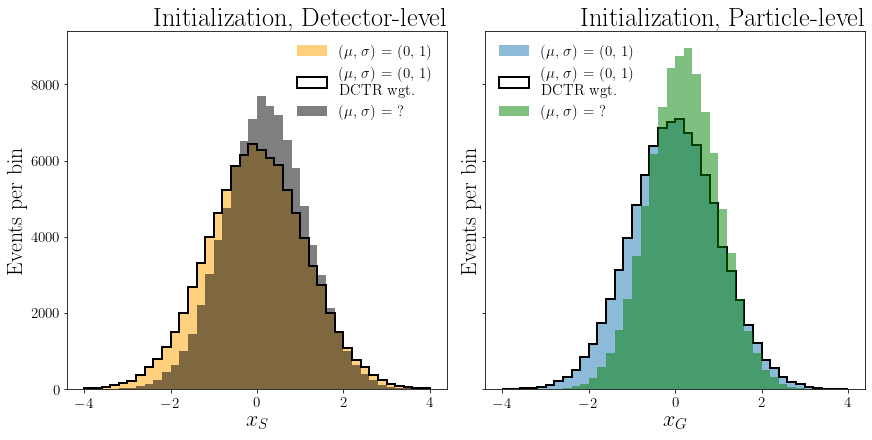

<Figure size 864x360 with 0 Axes>

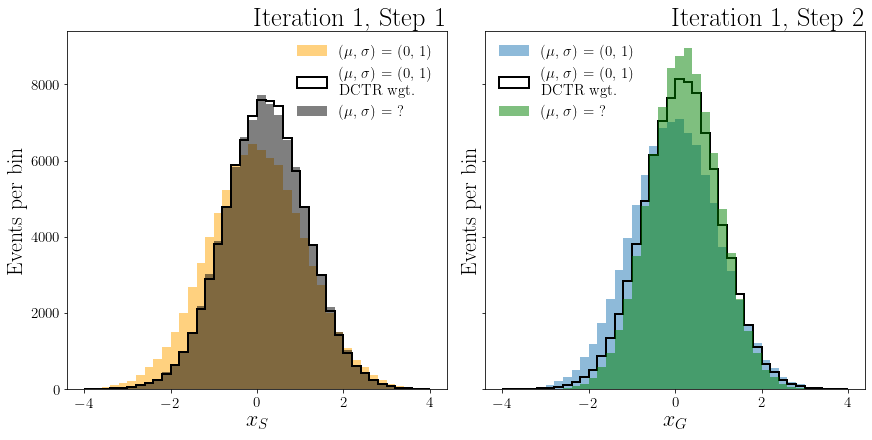

<Figure size 864x360 with 0 Axes>

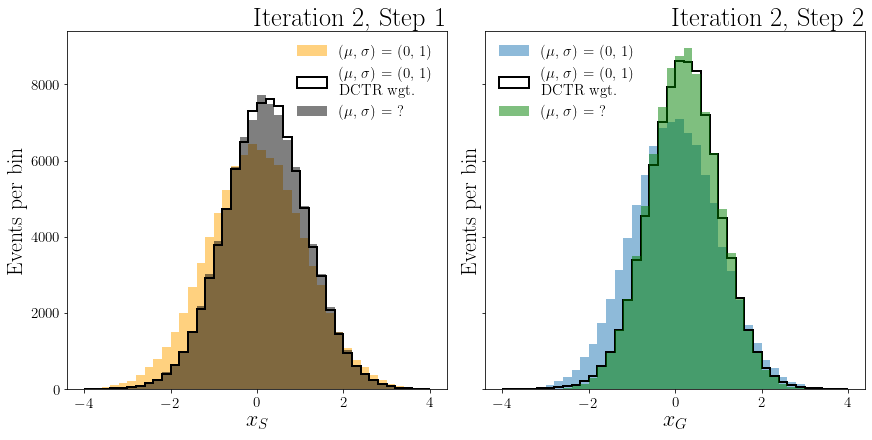

<Figure size 864x360 with 0 Axes>

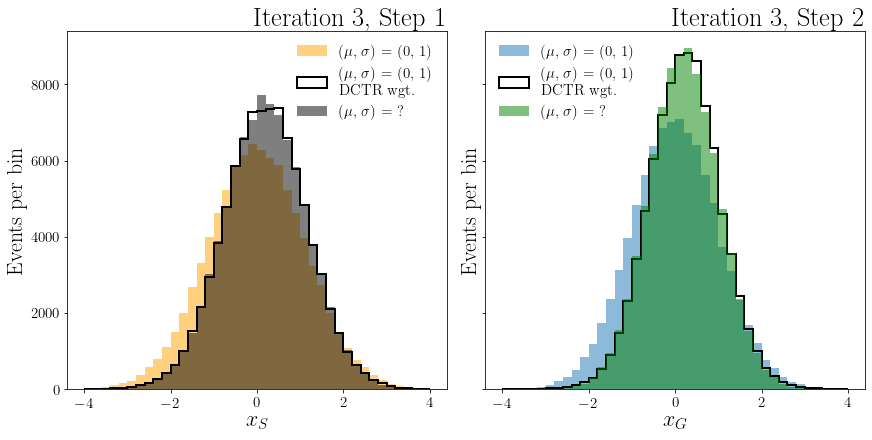

<Figure size 864x360 with 0 Axes>

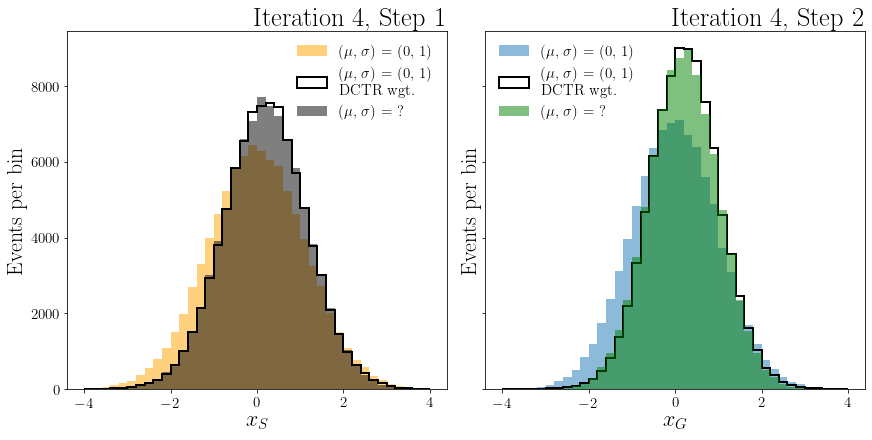

In [16]:
bins = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S[theta0_S!=dummyval],
                 bins=bins,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S[theta0_S!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights[i, 0, :][theta_unknown_S!=dummyval],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S[theta0_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S[theta0_S!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 0, :][theta0_S!=dummyval],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")